# Setup

In [1]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
from muutils.tensor_utils import string_dict_shapes
# TransformerLens imports
from transformer_lens import ActivationCache, HookedTransformer


# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# mechinterp stuff
from maze_transformer.mechinterp.plot_logits import plot_logits
from maze_transformer.mechinterp.logit_attrib_task import DLAProtocol, DLAProtocolFixed, token_after_fixed_start_token, LOGIT_ATTRIB_TASKS
from maze_transformer.mechinterp.logit_diff import logits_diff_multi
from maze_transformer.mechinterp.logit_lens import plot_logit_lens
from maze_transformer.mechinterp.direct_logit_attribution import plot_direct_logit_attribution
from maze_transformer.mechinterp.plot_attention import plot_attention_final_token
from maze_transformer.mechinterp.plot_weights import plot_important_neurons
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data



c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\maze-transformer-2cGx2R0F-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

# print the available tasks
print(f"{list(LOGIT_ATTRIB_TASKS.keys()) = }")

DEVICE = device(type='cuda')
list(LOGIT_ATTRIB_TASKS.keys()) = ['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']


expected tasks:
```
['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']
```

## Loading the model and dataset in

In [3]:
MODEL: ZanjHookedTransformer; DATASET: MazeDataset
MODEL, DATASET = load_model_with_test_data(
	model_path="../examples/wandb.jerpkipj.zanj",
	# model_path="../examples/model.hallway-insto.v17.zanj",
	# model_path="../examples/model.hallway-insto.final.zanj",
	# dataset_cfg_source=None,
	dataset_cfg_source=MazeDatasetConfig(
		name="hallway",
		grid_n=6,
		n_mazes=1,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
		maze_ctor_kwargs=dict(do_forks=False),
	),
	n_examples=100,
)

loaded model with 9.6M params (num_params = 9639484) from
../examples/wandb.jerpkipj.zanj
original model name: 'model.zanj_model_config.name = 'default'', changing to 'wandb.jerpkipj'
loaded dataset with 100 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g6-n100-a_dfs-h51432', 'sdc_hash': 21953628799579519491399527751453684974870664864302363176281422620152888051432, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 6, 'grid_shape': (6, 6), 'n_mazes': 100, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}


In [4]:
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

# print some info
print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

TASK_PROMPTS_TARGETS: dict[str, tuple[list[str], str]] = {
	task_name: task(DATASET_TOKENS)
	for task_name, task in LOGIT_ATTRIB_TASKS.items()
}

n_mazes: int = len(DATASET_TOKENS)
d_vocab: int = TOKENIZER.vocab_size

loaded 100 mazes
first maze:
<ADJLIST_START> (5,4) <--> (5,3) ; (4,4) <--> (4,3) ; (4,2) <--> (4,3) ; (5,5) <--> (4,5) ; (5,1) <--> (5,0) ; (5,2) <--> (5,1) ; (3,5) <--> (3,4) ; (5,2) <--> (5,3) ; (5,5) <--> (5,4) ; (3,5) <--> (4,5) ; (4,0) <--> (4,1) ; (5,0) <--> (4,0) ; (4,1) <--> (4,2) ; <ADJLIST_END> <ORIGIN_START> (4,4) <ORIGIN_END> <TARGET_START> (4,0) <TARGET_END> <PATH_START> (4,4) (4,3) (4,2) (4,1) (4,0) <PATH_END>
first maze, colored:
<ADJLIST_START> (5,4) <--> (5,3) ; (4,4) <--> (4,3) ; (4,2) <--> (4,3) ; (5,5) <--> (4,5) ; (5,1) <--> (5,0) ; (5,2) <--> (5,1) ; (3,5) <--> (3,4) ; (5,2) <--> (5,3) ; (5,5) <--> (5,4) ; (3,5) <--> (4,5) ; (4,0) <--> (4,1) ; (5,0) <--> (4,0) ; (4,1) <--> (4,2) ; <ADJLIST_END> <ORIGIN_START> (4,4) <ORIGIN_END> <TARGET_START> (4,0) <TARGET_END> <PATH_START> (4,4) (4,3) (4,2) (4,1) (4,0) <PATH_END>


# run model

In [5]:
TASK_LOGITS: dict[str, Float[torch.Tensor, "n_mazes seq_len d_vocab"]] = dict()
TASK_CACHES: dict[str, ActivationCache] = dict()
LAST_TOK_LOGITS: dict[str, Float[torch.Tensor, "n_mazes d_vocab"]] = dict()
PREDICTED_TOKENS: dict[str, list[str]] = dict()
PREDICTIONS_CORRECT: dict[str, Bool[torch.Tensor, "n_mazes"]] = dict()

for task_name, (prompts, targets) in TASK_PROMPTS_TARGETS.items():
	print(f"running task {task_name}")
	prompts_joined: list[str] = [" ".join(prompt) for prompt in prompts]
	# logits, cache = MODEL.run_with_cache(prompts_joined)
	logits = MODEL(prompts_joined)
	TASK_LOGITS[task_name] = logits
	# TASK_CACHES[task_name] = cache
	LAST_TOK_LOGITS[task_name] = logits[:, -1, :].cpu()
	# TOKENIZER.decode(LAST_TOK_LOGITS.argmax(dim=-1).tolist())
	PREDICTED_TOKENS[task_name] = TOKENIZER.decode(LAST_TOK_LOGITS[task_name].argmax(dim=-1).tolist())
	PREDICTIONS_CORRECT[task_name] = torch.tensor([
		pred == target 
		for pred, target in zip(PREDICTED_TOKENS[task_name], targets)
	])



running task path_start
running task origin_after_path_start
running task first_path_choice
running task path_end
running task final_before_path_end
running task rand_path_token
running task rand_path_token_non_endpoint


acc_means = {'path_start': 1.0, 'origin_after_path_start': 0.8299999833106995, 'first_path_choice': 0.6600000262260437, 'path_end': 0.7400000095367432, 'final_before_path_end': 0.8999999761581421, 'rand_path_token': 0.8799999952316284, 'rand_path_token_non_endpoint': 0.9200000166893005}


Text(0.5, 1.0, "Prediction accuracy across tasks\nmodel: 'wandb.jerpkipj'\ndataset: 'hallway-g6-n100-a_dfs-h51432'")

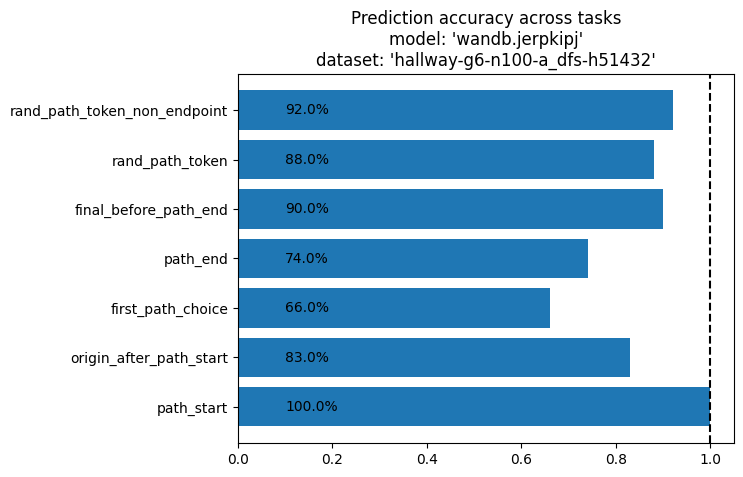

In [6]:
# plot bar chart of prediction accuracy across tasks

acc_means = {
	key: correct.float().mean().item() 
	for key, correct in PREDICTIONS_CORRECT.items()
}
print(f"{acc_means = }")
fig, ax = plt.subplots()
# horizontal bars
ax.barh(
	y=list(acc_means.keys()),
	width=list(acc_means.values()),
)
# add percentage labels
for i, (task_name, acc) in enumerate(acc_means.items()):
	ax.text(
		x=0.1,
		y=i,
		s=f"{acc * 100:.1f}%",
		verticalalignment="center",
	)
# black line at 1.0
ax.axvline(x=1.0, color="black", linestyle="--")
plt.title(f"Prediction accuracy across tasks\nmodel: '{MODEL.config.name}'\ndataset: '{DATASET.cfg.to_fname()}'")